In [61]:
import mesh_renderer
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation



import camera_utils
import rasterize_triangles

from IPython.display import Image, HTML
import PIL
from stl import mesh

from io import BytesIO
def drawarray(a, fmt="png"):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return Image(data=f.getvalue())

In [62]:
def drawarrays(arrays):
    ratio = arrays[0].shape[1] / arrays[0].shape[0]
    fig, ax = plt.subplots(figsize=(5, 5 * ratio))
    im = ax.imshow(arrays[0])
    def update(i):
        im.set_data(arrays[i])
    plt.axis('off')
    ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(arrays)), interval=50)
    plt.close()
    return ani
    
def get_triangles(bust):
    indices = {}
    indices_list = []
    triangles = []
    for tri in bust.vectors:
        triangle = []
        for idx, v in enumerate(tri):
            val = tuple(v)
            if val not in indices:
                index = len(indices)
                indices_list.append(val)
                indices[val] = index
            else:
                index = indices[val]
            triangle.append(index)
        triangles.append(triangle)
    return indices_list, triangles
            

In [63]:
bust = mesh.Mesh.from_file("../data/Slic3r_friendly_pt5_scale_tilted.stl")
vertices, triangles = get_triangles(bust)
triangles = np.array(triangles)
vertices = np.array(vertices)
vertices -= vertices.mean(axis=0, keepdims=True)
vertices = (vertices / np.array(vertices).max()) * 2

cube_vertices = np.array([[-1, -1, 1], [-1, -1, -1], [-1, 1, -1], [-1, 1, 1], [1, -1, 1],
         [1, -1, -1], [1, 1, -1], [1, 1, 1]])
cube_triangles = np.array([[0, 1, 2], [2, 3, 0], [3, 2, 6], [6, 7, 3], [7, 6, 5], [5, 4, 7],
         [4, 5, 1], [1, 0, 4], [5, 6, 2], [2, 1, 5], [7, 4, 0], [0, 3, 7]], dtype=np.int32)


In [256]:
def render_cube(*, vertices, normals, triangles, angles, image_height=300, image_width=300):
    model_rotation = camera_utils.euler_matrices(angles)[0, :3, :3]
    vertices_world_space = tf.reshape(
        tf.matmul(vertices, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    # camera position:
    eye = tf.constant([[0.0, 0.0, 6.0]], dtype=tf.float32)
    
    lightbulb = tf.constant([[0.0, 0.0, 6.0]] +
                            [[0.0, 5.0, 6.0],
                             [0.0, -5.0, 6.0],
                             [-5.0, 0.0, 6.0],
                             [5.0, 0.0, 6.0]], dtype=tf.float32)
    center = tf.constant([[0.0, 0.0, 0.0]], dtype=tf.float32)
    world_up = tf.constant([[0.0, 1.0, 0.0]], dtype=tf.float32)
    
    # [[min-x, min-y, min-z]]
    min_vertex = tf.reduce_min(vertices, axis=0, keepdims=True)
    # [[max-x, max-y, max-z]]
    max_vertex = tf.reduce_max(vertices, axis=0, keepdims=True)
    vertex_diffuse_colors = tf.reshape((vertices - min_vertex) / (max_vertex - min_vertex),
                                       [1, vertices.get_shape()[0].value, 3])
    # vertex_diffuse_colors = tf.ones_like(vertices_world_space, dtype=tf.float32) * tf.r
    light_positions = tf.expand_dims(lightbulb, axis=0)
    light_intensities = tf.ones([1, 1, 3], dtype=tf.float32)
    ambient_color = tf.constant([[0.0, 0.0, 0.0]])
    
    vertex_positions = tf.reshape(
        tf.matmul(vertices, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    desired_normals = tf.reshape(
        tf.matmul(normals, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    render = mesh_renderer.mesh_renderer(
        vertex_positions, triangles, desired_normals,
        vertex_diffuse_colors, eye, center, world_up, light_positions,
        light_intensities, image_width, image_height,
        ambient_color=ambient_color,
    )
    return tf.reshape(tf.minimum(render, 1.0), [image_height, image_width, 4])


def build_nodes(*, object_vertices, object_triangles,
                image_height=300, image_width=300):
    object_vertices = tf.constant(object_vertices, dtype=tf.float32)
    object_normals = tf.nn.l2_normalize(object_vertices, dim=1)
    target_angles = tf.placeholder(tf.float32, shape=[None, 3])
    starting_angles = tf.placeholder(tf.float32, shape=[None, 3])
    training = tf.placeholder_with_default(False, shape=())
    desired_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                     normals=object_normals,
                                                     triangles=object_triangles,
                                                     angles=x[None, :],
                                                     image_height=image_height,
                                                     image_width=image_width),
                               target_angles)
    starting_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                      normals=object_normals,
                                                      triangles=object_triangles,
                                                      angles=x[None, :],
                                                      image_height=image_height,
                                                      image_width=image_width),
                                starting_angles)
    
    # by observing the rendered image, predict how to change the state
    # of the world to make things better
    sizes = [
        (128, 5),
        (128, 5),
        (128, 5),
    ]
    out = tf.concat([desired_render[:, :, :, :3]], axis=-1)
    for filters, kernel_size in sizes:
        out = tf.nn.leaky_relu(tf.layers.conv2d(out, filters, kernel_size, strides=(2, 2),
                               activation=None,
                               kernel_initializer=tf.random_uniform_initializer(-0.002, 0.002),
                               bias_initializer=tf.zeros_initializer()))
    predicted_angles = tf.contrib.layers.fully_connected(
        tf.reshape(out, [tf.shape(out)[0], out.get_shape()[1].value * out.get_shape()[2].value * out.get_shape()[3].value]),
        3,
        activation_fn=None,
        biases_initializer=tf.zeros_initializer(),
        weights_initializer=tf.random_uniform_initializer(-0.002, 0.002))
    render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                             normals=object_normals,
                                             triangles=object_triangles,
                                             angles=x[None, :],
                                             image_height=image_height,
                                             image_width=image_width),
                        predicted_angles)
    
    
    #  + starting_angles
    #loss = tf.reduce_mean(tf.abs(render - desired_render))
    loss = tf.reduce_mean(tf.square(predicted_angles - target_angles))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    vars = tf.trainable_variables()
    grads = tf.gradients(loss, vars)
    grads, _ = tf.clip_by_global_norm(grads, 1.0)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(zip(grads, vars))
    return {
        "loss": loss,
        "train_op": train_op,
        "render": render,
        "desired_render": desired_render,
        "predicted_angles": predicted_angles,
        "target_angles": target_angles,
        "starting_angles": starting_angles,
        "training": training,
    }



In [270]:
def build_nodes_simple(*, object_vertices, object_triangles,
                       image_height=300, image_width=300,
                       init_val=None):
    if init_val is None:
        init_val = [[-1.16, 0.0, 3.48]]
    object_vertices = tf.constant(object_vertices, dtype=tf.float32)
    object_normals = tf.nn.l2_normalize(object_vertices, dim=1)
    target_angles = tf.placeholder(tf.float32, shape=[None, 3])
    starting_angles = tf.placeholder(tf.float32, shape=[None, 3])
    training = tf.placeholder_with_default(False, shape=())
    desired_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                     normals=object_normals,
                                                     triangles=object_triangles,
                                                     angles=x[None, :],
                                                     image_height=image_height,
                                                     image_width=image_width),
                               target_angles)
    starting_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                      normals=object_normals,
                                                      triangles=object_triangles,
                                                      angles=x[None, :],
                                                      image_height=image_height,
                                                      image_width=image_width),
                                starting_angles)
    
    # by observing the rendered image, predict how to change the state
    # of the world to make things better
    predicted_angles = tf.Variable(init_val, dtype=tf.float32)
    render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                             normals=object_normals,
                                             triangles=object_triangles,
                                             angles=x[None, :],
                                             image_height=image_height,
                                             image_width=image_width), predicted_angles)
    
    
    #  + starting_angles
    loss = tf.reduce_mean(tf.abs(render - desired_render))
    # optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    optimizer = tf.train.MomentumOptimizer(0.7, 0.1)
    vars = tf.trainable_variables()
    grads = tf.gradients(loss, vars)
    grads, _ = tf.clip_by_global_norm(grads, 1.0)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(zip(grads, vars))
    return {
        "loss": loss,
        "train_op": train_op,
        "render": render,
        "desired_render": desired_render,
        "predicted_angles": predicted_angles,
        "target_angles": target_angles,
        "starting_angles": starting_angles,
        "training": training,   
    }

In [263]:
tf.reset_default_graph()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/loc

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_1/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_2/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

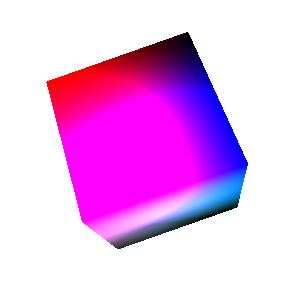

In [264]:

sess = tf.InteractiveSession()
nodes = build_nodes_simple(#object_triangles=triangles, object_vertices=vertices,
                           object_triangles=cube_triangles, object_vertices=cube_vertices,
                           image_height=300, image_width=300,
                           init_val=[[-1.16, 0.00, 0.0]])
sess.run(tf.global_variables_initializer())
desire = sess.run(nodes["desired_render"], {nodes["target_angles"]: [[-1.16, 0.00, 3.48]],
                     nodes["training"]: True})
drawarray(desire[0] * 255)

In [265]:
errors = []
renders = []
ema_l = None
for i in range(300):
    l, _, temp, desire = sess.run([nodes["loss"], nodes["train_op"], nodes["render"], nodes["desired_render"]],
                    {nodes["target_angles"]: [[-1.16, 0.00, 3.48]],
                     nodes["training"]: True})
    print("{} Loss {}".format(i, l))
    errors.append(l)
    renders.append(temp[0])
        
    if l < 0.01:
        break

0 Loss 0.08954150229692459
1 Loss 0.08857975155115128
2 Loss 0.08728053420782089
3 Loss 0.08652787655591965
4 Loss 0.08577340841293335
5 Loss 0.08535069972276688
6 Loss 0.08485245704650879
7 Loss 0.08454339951276779
8 Loss 0.08422344923019409
9 Loss 0.0842461884021759
10 Loss 0.08401910215616226
11 Loss 0.08393069356679916
12 Loss 0.08397528529167175
13 Loss 0.0841543972492218
14 Loss 0.08425110578536987
15 Loss 0.0842769667506218
16 Loss 0.0843287780880928
17 Loss 0.08437509089708328
18 Loss 0.0844397023320198
19 Loss 0.084502674639225
20 Loss 0.08426651358604431
21 Loss 0.08443546295166016
22 Loss 0.08436653763055801
23 Loss 0.08453010022640228
24 Loss 0.08476301282644272
25 Loss 0.08448141068220139
26 Loss 0.08466850966215134
27 Loss 0.08464015275239944
28 Loss 0.08444119244813919
29 Loss 0.08434057980775833
30 Loss 0.08436175435781479
31 Loss 0.08425252884626389
32 Loss 0.08418257534503937
33 Loss 0.0842665284872055
34 Loss 0.0843447595834732
35 Loss 0.08399630337953568
36 Loss 0.0

288 Loss 0.08373236656188965
289 Loss 0.08369404077529907
290 Loss 0.08392824977636337
291 Loss 0.0838586762547493
292 Loss 0.08373776823282242
293 Loss 0.08382734656333923
294 Loss 0.08377636969089508
295 Loss 0.08368777483701706
296 Loss 0.08367831259965897
297 Loss 0.08382362127304077
298 Loss 0.08374852687120438
299 Loss 0.08370578289031982


In [68]:
# errors = []
# scales = []
# sess = tf.InteractiveSession()
# nodes = build_nodes(#object_triangles=triangles, object_vertices=vertices,
#                     object_triangles=cube_triangles, object_vertices=cube_vertices,
#                     image_height=300, image_width=300)
# sess.run(tf.global_variables_initializer())
# noise_level = 10.0
# ema_l = None
# batch_size = 8
# time_without_improvement = 0
# for i in range(1000):
#     target = np.array([[0.0, 0.0, 0.0] for _ in range(batch_size)])
#     l, _ = sess.run([nodes["loss"], nodes["train_op"]],
#                     {nodes["target_angles"]: target + np.random.uniform(-noise_level, noise_level, size=(batch_size, 3)),
#                      nodes["training"]: True})
#     print("{} Loss {}, imp={}".format(i, l, time_without_improvement))
#     errors.append(l)
#     scales.append(noise_level)
#     if ema_l is None:
#         ema_l = l
#     else:
#         ema_l = ema_l * 0.99 + 0.01 * l
#     if ema_l < 0.01 or time_without_improvement > 150:
#         if noise_level >= 30:
#             break
#         print("Increasing noise level {}".format(noise_level))
#         ema_l = None
#         noise_level *= 1.1
#         time_without_improvement = 0
#     else:
#         time_without_improvement += 1
#         

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_3/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_4/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_5/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

0 Loss 39.17331314086914, imp=0
1 Loss 31.87651252746582, imp=1
2 Loss 38.82591247558594, imp=2


KeyboardInterrupt: 

In [68]:
# errors = []
# scales = []
# sess = tf.InteractiveSession()
# nodes = build_nodes(#object_triangles=triangles, object_vertices=vertices,
#                     object_triangles=cube_triangles, object_vertices=cube_vertices,
#                     image_height=300, image_width=300)
# sess.run(tf.global_variables_initializer())
# noise_level = 10.0
# ema_l = None
# batch_size = 8
# time_without_improvement = 0
# for i in range(1000):
#     target = np.array([[0.0, 0.0, 0.0] for _ in range(batch_size)])
#     l, _ = sess.run([nodes["loss"], nodes["train_op"]],
#                     {nodes["target_angles"]: target + np.random.uniform(-noise_level, noise_level, size=(batch_size, 3)),
#                      nodes["training"]: True})
#     print("{} Loss {}, imp={}".format(i, l, time_without_improvement))
#     errors.append(l)
#     scales.append(noise_level)
#     if ema_l is None:
#         ema_l = l
#     else:
#         ema_l = ema_l * 0.99 + 0.01 * l
#     if ema_l < 0.01 or time_without_improvement > 150:
#         if noise_level >= 30:
#             break
#         print("Increasing noise level {}".format(noise_level))
#         ema_l = None
#         noise_level *= 1.1
#         time_without_improvement = 0
#     else:
#         time_without_improvement += 1
#         

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_3/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_4/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_5/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/l

0 Loss 39.17331314086914, imp=0
1 Loss 31.87651252746582, imp=1
2 Loss 38.82591247558594, imp=2


KeyboardInterrupt: 

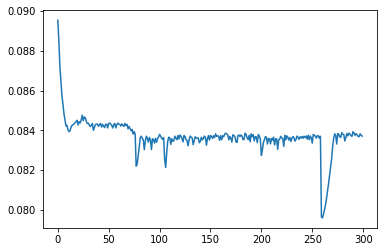

In [266]:
plt.plot(errors)
#plt.plot(scales)

In [102]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32_ref>]

In [271]:
l, pred = sess.run([nodes["loss"], nodes["predicted_angles"]], {nodes["target_angles"]: [[-1.16, 0.00, 3.48]]})
print(pred)

[[-1.399277   -0.1740461   0.21634331]]


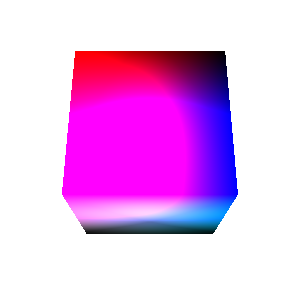

In [268]:
for i in range(400):
    l, pred, temp, desire = sess.run([nodes["loss"], nodes["predicted_angles"], nodes["render"], nodes["desired_render"]],
                              {nodes["target_angles"]: [[-20.0, 0.00, 3.14]]})
    renders.append(temp[0])
    break
drawarray(np.minimum(desire[0], 1.0) * 255)

In [269]:
HTML(drawarrays(renders).to_html5_video())